In [860]:
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Lambda, LeakyReLU
from keras.models import Model
from keras.optimizers import Adadelta, Adagrad, Adam, SGD
from skopt.benchmarks import branin, bench3
import numpy as np
import theano.tensor as T
%matplotlib inline
from IPython import display

from deap import benchmarks

import matplotlib.pyplot as plt

A = [[0.5, 0.5], [0.25, 0.25], [0.25, 0.75], [0.75, 0.25], [0.75, 0.75]]
C = [0.002, 0.005, 0.005, 0.005, 0.005]

def shekel_arg0(sol):
    return benchmarks.shekel(sol, A, C)[0]

def func(x):
    #return shekel_arg0((x[0], x[1]))
    #return x**4 - 16*x**2+5*x
    #return 1/(2+(x-2)**2) + 1/(8+(x-5)**2)
    
    return x*np.sin(x) + x*np.cos(2.*x)
    #return np.sin(x)
    #return np.array([bench3(a) for a in x])
    #return x[:, 0] + x[:, 1]
    return np.array([branin((example[0], example[[1]])) for example in x])

def gaussian_kernel(A, B):
    A_ = A[:, None, :]
    B_ = B[None, :, :]
    #sigmas = [2, 5, 10, 20, 40, 80, 160]
    # sigmas = [w*h*c, (w*h*c)**2]
    # sigmas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 200, 400]
    #sigmas = [0.1, 1, 10]
    sigmas = [1]
    out = 0
    for sigma in sigmas:
        m = ((A_ - B_) ** 2).sum(axis=2)
        out += T.exp(-m / (2 * sigma**2))
    return out.sum()

def mmd(X, Y):
    phi = gaussian_kernel
    a = phi(X, X)
    b = phi(X, Y)
    c = phi(Y, Y)
    N = X.shape[0]
    M = Y.shape[0]
    mmd_sqr = 1. / (N**2) * a - (2. / (N * M)) * b + (1. / M**2) * c
    return T.sqrt(mmd_sqr)

nb_feat = 1

In [861]:
x = Input((nb_feat,))
inp = x
x = Dense(800)(x)
x = Activation('tanh')(x)
x = Dense(1)(x)
outp = x
predictor = Model(inp, outp)
predictor.compile(loss='mse', optimizer=Adam(lr=0.01))

x = Input((10,))
inp = x
x = Dense(300)(x)
x = Activation('tanh')(x)
x = Dense(300)(x)
x = Activation('tanh')(x)
x = Dense(1)(x)
#x = Lambda(lambda a:a*30)(x)
def norm(a):
    #return a - a.mean(axis=0, keepdims=True) / (1e-12 +a.std(axis=0, keepdims=True))
    return (a-a.min(axis=0, keepdims=True))/(1e-12 + a.max(axis=0, keepdims=True)-a.min(axis=0, keepdims=True))
#x = Lambda(lambda a:norm(a))(x)
outp = x
sampler = Model(inp, outp)
sampler_mmd = Model(inp, outp)


def loss(x_true, x_pred):
    lbd =0.13
    return predictor(x_pred) #- lbd * T.std(x_pred, axis=0).mean()

    
sampler.compile(loss=loss, optimizer=Adam(lr=0.0001))

sampler_mmd.compile(loss=mmd, optimizer=Adam(lr=0.001))

In [862]:
def prior_sample(size=10):
    return np.random.normal(0, 10, size=size)

def plot_1d(x, y, **kw):
    plt.plot(x, y, **kw)
plt_func = plot_1d
x_linspace = np.linspace(-30, 30, 1000)


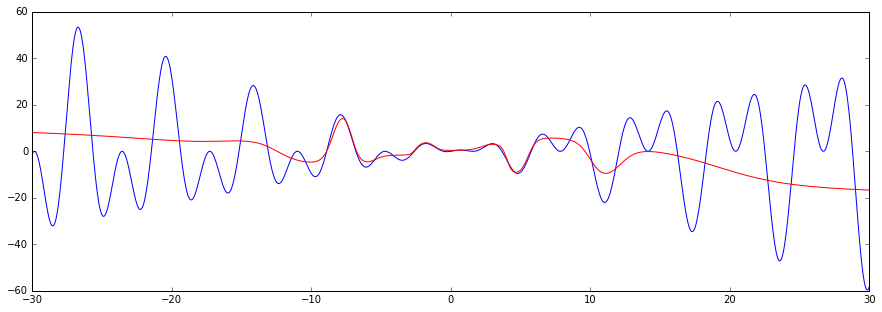

In [863]:
all_y = []
for iter_ in range(200):
    x_new = prior_sample(size=(256, nb_feat))
    y_new = func(x_new)
    predictor.fit(x_new, y_new, verbose=0)
    
    display.clear_output(wait=True)

    fig = plt.figure(figsize=(15, 5))
    plt_func(x_linspace, func(x_linspace), c='blue')
    plt_func(x_linspace, predictor.predict(x_linspace), c='red')
    display.display(plt.gcf())
    plt.close(fig)
display.clear_output(wait=True)

## fit predictor only

## bootstrap sampler with inputs from the prior

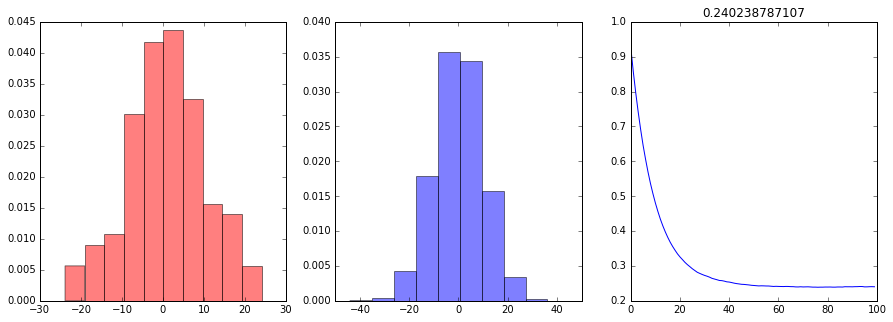

In [826]:
rg = prior_sample(size=(100000, nb_feat))
batch_size = 500
avg_loss = 1
losses = []
for iter_ in range(100):
    
    # fit sampler
    
    # get inputs randomy from prior
    z = np.random.uniform(-1, 1, size=(batch_size, 10))
    x = sampler_mmd.predict(z)
    
    # get inputs from sampler
    r = prior_sample(size=(batch_size, nb_feat))
    sampler_mmd.fit(z, r, verbose=0)
    
    # compute loss
    avg_loss = 0.9 * avg_loss + 0.1 * np.mean(sampler_mmd.history.history['loss'])
    losses.append(avg_loss)
    fig = plt.figure(figsize=(15, 5))
    
    
    # fig
    display.clear_output(wait=True)
    
    z = np.random.uniform(-1, 1, size=(1000, 10))
    x = sampler_mmd.predict(z)
    plt.subplot(1, 3, 1)
    plt.hist(x, color='red', alpha=0.5, normed=True)
    plt.subplot(1, 3, 2)
    plt.hist(rg, color='blue', alpha=0.5, normed=True)
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.title(losses[-1])
    #plt.show()
    display.display(fig)
    plt.close(fig)

In [827]:
avg_loss = 0

## optimize

KeyboardInterrupt: 

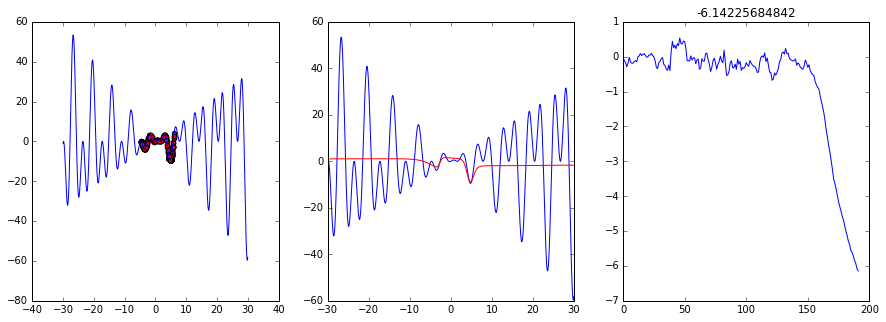

In [828]:
batch_size = 100
all_y = []
losses = []
for iter_ in range(1000):
    
    z = np.random.uniform(-1, 1, size=(batch_size, 10))

    # fit predictor
    
    x_new = sampler.predict(z)
    #x_new = prior_sample(size=(batch_size, nb_feat))
    y_new = func(x_new)
    all_y.append(np.mean(y_new))
    
    # fit sampler
    
    predictor.fit(x_new, y_new, verbose=0)
    z = np.random.uniform(-1, 1, size=(batch_size, 10))
    sampler.fit(z, x_new, verbose=0)
    avg_loss = 0.9 * avg_loss + 0.1 * np.mean(sampler.history.history['loss'])

    losses.append(avg_loss)
    display.clear_output(wait=True)

    x = np.linspace(-30, 30, 1000)
    z = np.random.uniform(-1, 1, size=(1000, 10))
    a = sampler.predict(z)
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, func(x))
    plt.scatter(a, func(a), c='red')
    plt.subplot(1, 3, 2)
    plt.plot(x, func(x), c='blue')
    plt.plot(x, predictor.predict(x), c='red')
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.title(avg_loss)
    display.display(plt.gcf())
    plt.close(fig)
display.clear_output(wait=True)

-6.8211


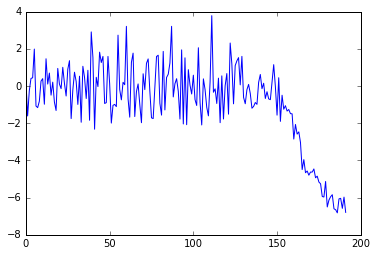

In [829]:
plt.plot(all_y)
print(min(all_y))

-0.999971


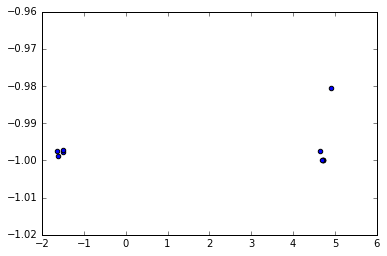

In [806]:
z = np.random.uniform(-1, 1, size=(10, 10))
best = sampler.predict(z)
plt.scatter(best, func(best))
print(np.min(func(best)))

In [ ]:
xx = np.linspace(-5, 10, 100)
yy = np.linspace(0, 15, 100)
xx, yy = np.meshgrid(xx, yy)

X = np.vstack((xx.flatten(), yy.flatten())).T
val = func(X)
val = val.reshape(xx.shape)
cb = plt.contourf(xx, yy ,val)
plt.scatter(best[:, 0], best[:, 1], c='red')
plt.colorbar(cb)